# Reduced Ion Velocity Distribution Function $f_i(v_\parallel)$ using Monte-Carlo integration

author: Louis Richard\
Example to compute and plot reduced ion distributions from FPI

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from pyrfu import mms, pyrf
from pyrfu.plot import plot_spectr, plot_line, use_pyrfu_style

use_pyrfu_style(usetex=True)

Load IGRF coefficients ...


## Load data

### Define time interval and spacecraft index

In [2]:
mms.db_init(default="local", local="/Volumes/mms")
tint = ["2017-08-04T09:00:00", "2017-08-04T09:02:28"]
mms_id = 1

[29-Jan-26 16:34:59] INFO: Updating MMS data access configuration in /Users/louisr/Dropbox/Documents/irfu-python/.venv/lib/python3.14/site-packages/pyrfu/mms/config.json...
[29-Jan-26 16:34:59] INFO: Updating MMS SDC credentials in /Users/louisr/.config/python_keyring...


### Get the magnetic field

In [3]:
b_dmpa = mms.get_data("b_dmpa_fgm_brst_l2", tint, mms_id)

[29-Jan-26 16:34:59] INFO: Loading mms1_fgm_b_dmpa_brst_l2...


In [4]:
sc_pot = mms.get_data("v_edp_brst_l2", tint, mms_id)

[29-Jan-26 16:34:59] INFO: Loading mms1_edp_scpot_brst_l2...


### Get spacecraft attitude (for conversion between Geocentric Solar Ecliptic to spacecrat coordinates)

In [5]:
defatt = mms.load_ancillary("defatt", tint, mms_id)

[29-Jan-26 16:35:01] INFO: Loading ancillary defatt files...


### Get the ion velocity distribution skymap and the uncertainties ($\delta f / f = 1/\sqrt{n}$ with $n$ the number of counts)

In [6]:
vdf_i = mms.get_data("pdi_fpi_brst_l2", tint, mms_id)
vdf_i_err = mms.get_data("pderri_fpi_brst_l2", tint, mms_id)

[29-Jan-26 16:35:05] INFO: Loading mms1_dis_dist_brst...
[29-Jan-26 16:35:05] INFO: Loading mms1_dis_disterr_brst...


## Define the coordinates system for projection of the distribution function

- x is along the local magnetic field
- y and z are arbitrarly constructed perpandicular to x with z most aligned with spacecraft spin axis

In [7]:
x_hat = pyrf.resample(b_dmpa, vdf_i)
x_hat.data /= pyrf.norm(x_hat).data[:, np.newaxis]
z_hat = pyrf.ts_vec_xyz(
    vdf_i.time.data, np.array([0, 0, 1]) * np.ones((len(vdf_i.time), 3))
)
y_hat = pyrf.cross(z_hat, x_hat)
y_hat.data /= pyrf.norm(y_hat).data[:, np.newaxis]
z_hat = pyrf.cross(x_hat, y_hat)
z_hat.data /= pyrf.norm(z_hat).data[:, np.newaxis]

xyz = np.transpose(np.stack([x_hat.data, y_hat.data, z_hat.data]), [1, 2, 0])
xyz = pyrf.ts_tensor_xyz(vdf_i.time.data, xyz)

### Define velocity grid along the three vectors

In [8]:
vpara_lim = np.array([-2e3, 2e3], dtype=np.float64)
vg_para = np.linspace(vpara_lim[0], vpara_lim[1], 100)

### Reduce the distributions

In [9]:
f1dpara = mms.reduce(
    vdf_i,
    dim="1d",
    xyz=xyz,
    n_mc=200,
    vg=vg_para * 1e3,
    lower_e_lim=30.0,
    sc_pot=sc_pot,
)
f1dpara = f1dpara.assign_coords(vx=f1dpara.vx.data / 1e3)

100%|█████████████████████| 987/987 [00:12<00:00, 78.71it/s]


### Plot

[29-Jan-26 16:35:18] WARNING: <>:6: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.

[29-Jan-26 16:35:18] WARNING: <>:6: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.

[29-Jan-26 16:35:18] WARNING: /var/folders/z6/4tzcn4qs67j8glvrfvkzlkg80000gn/T/ipykernel_79820/2824225912.py:6: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  axs[0].set_ylabel("$B_{dmpa}~[\mathrm{nT}]$")



(np.float64(17382.375), np.float64(17382.376712962963))

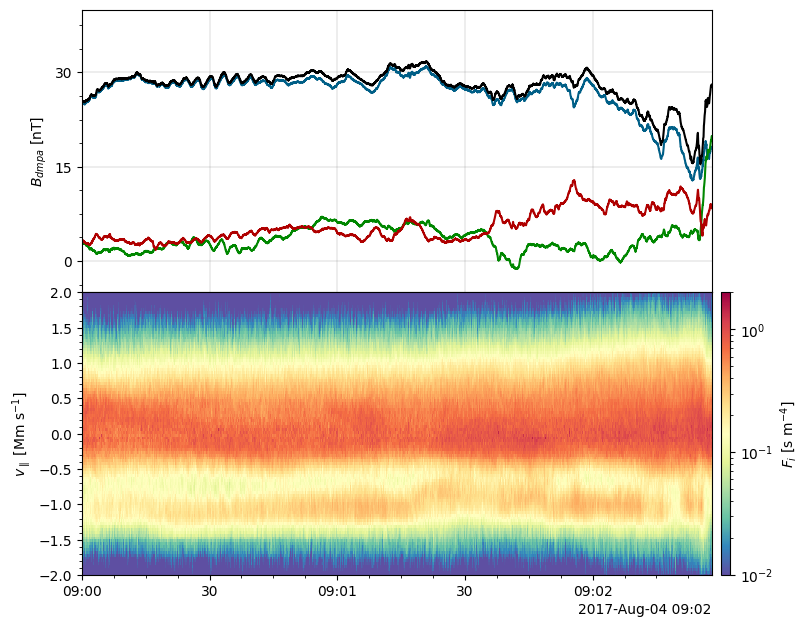

In [10]:
f, axs = plt.subplots(2, sharex="all", figsize=(9, 6.5))
f.subplots_adjust(hspace=0.0, left=0.15, right=0.85, bottom=0.08, top=0.95)
plot_line(axs[0], b_dmpa)
plot_line(axs[0], pyrf.norm(b_dmpa), color="k")
axs[0].set_ylim([-5, 40])
axs[0].set_ylabel("$B_{dmpa}~[\mathrm{nT}]$")

axs[1], cax1 = plot_spectr(
    axs[1], f1dpara, cscale="log", clim=[1e-2, 2e0], cmap="Spectral_r"
)
axs[1].set_ylim([-2, 2])
axs[1].set_ylabel("$v_\\parallel~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")
cax1.set_ylabel("$F_i~[\\mathrm{s}~\\mathrm{m}^{-4}]$")

axs[-1].set_xlim(pyrf.iso86012datetime64(np.array(tint)))

## Plot a 1D reduced distribution and fit

### Select the ion distribution

In [11]:
t_sel = np.datetime64("2017-08-04T09:01:08.105711000")
f1dpara_sel = f1dpara.sel(time=t_sel)

### Define Maxwellian and two components models

In [12]:
from scipy import constants, optimize

# Define Maxwellian distribution function


def maxwellian(v, n, u, t):
    m_i = constants.proton_mass
    v_th = np.sqrt(2 * constants.electron_volt * t / m_i)
    coeff = n / (np.sqrt(np.pi) * v_th)
    exponent = -((v - u) ** 2) / v_th**2
    return coeff * np.exp(exponent)


# Define two-component Maxwellian model


def two_components(v, n1, u1, t1, n2, u2, t2):
    return maxwellian(v, n1, u1, t1) + maxwellian(v, n2, u2, t2)

### Fit the reduced distribution

In [13]:
# Fit the two-component Maxwellian model to the data
popt, _ = optimize.curve_fit(
    two_components,
    f1dpara.vx.data * 1e6,
    f1dpara.data[454, :],
    p0=[0.2e6, -1100e3, 520, 1e6, 100e3, 1700],
)

# Compute the fitted components
core = maxwellian(f1dpara.vx.data * 1e6, *popt[3:])
beam = maxwellian(f1dpara.vx.data * 1e6, *popt[:3])
tota = two_components(f1dpara.vx.data * 1e6, *popt)

## Plot

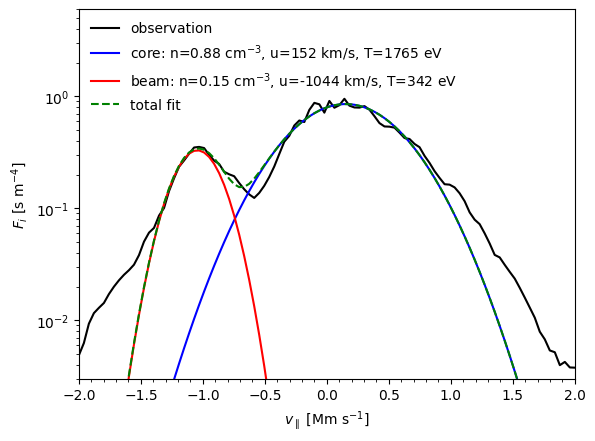

In [14]:
f, ax = plt.subplots(1)
ax.semilogy(f1dpara.vx.data, f1dpara.data[454, :], color="k", label="observation")

ax.semilogy(
    f1dpara.vx.data,
    core,
    color="b",
    label=f"core: n={popt[3]*1e-6:.2f} cm$^{{-3}}$, u={popt[4]*1e-3:.0f} km/s, T={popt[5]:.0f} eV",
)
ax.semilogy(
    f1dpara.vx.data,
    beam,
    color="r",
    label=f"beam: n={popt[0]*1e-6:.2f} cm$^{{-3}}$, u={popt[1]*1e-3:.0f} km/s, T={popt[2]:.0f} eV",
)
ax.semilogy(f1dpara.vx.data, tota, color="g", linestyle="--", label="total fit")

ax.set_ylim([3e-3, 6e0])
ax.set_xlim([-2, 2])
ax.set_xlabel(r"$v_\parallel~[\mathrm{Mm}~\mathrm{s}^{-1}]$")
ax.set_ylabel(r"$F_i~[\mathrm{s}~\mathrm{m}^{-4}]$")

ax.legend(loc="upper left")